# Clustering playground

In [1]:
%matplotlib inline

from gensim.models import Word2Vec
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import cluster
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
from sklearn.metrics.cluster import contingency_matrix
import matplotlib.cm as cm
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords as sw

stopwords = sw.words('german')
# gensims LineSentence generator replaces umlauts with 
# u, a or o so add these variants to the stopwordlist
for stopword in stopwords:
    stopword = stopword.replace(u'ü', 'u')
    stopword = stopword.replace(u'ö', 'o')
    stopword = stopword.replace(u'ä', 'a')
    if stopword not in stopwords:
        stopwords.append(stopword)

/Users/daniel/Library/Python/2.7/lib/python/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## load data

In [2]:
category_names = ['Sonstiges', 'Aktuell', 'Lifestyle', 
          'Wirtschaft', 'Finanzen', 'Ausland', 'Lokal', 
          'Politik', 'Sport', 'Technologie', 'Kultur']

num_models = len(category_names)

# the list of full corpora
fulldata_paths = [(x, "corpus/corpus{}.txt".format(x)) for x in category_names]

# the corpora with a fixed split for training and validation
train_paths = [(x, "data/corpus{}.training.txt".format(x)) for x in category_names]
validation_paths = [(x, "data/corpus{}.validation.txt".format(x)) for x in category_names]

base_model = Word2Vec.load('../wiki/data/wiki.de.200dim.word2vec.model')

In [3]:
def load_sets(paths):
    X, y = [], []

    for name, path in paths:
        with open(path) as cur_file:
            for line in cur_file:
                tokens = [x for x in line.split() if x not in stopwords]
                if len(tokens) > 0:
                    X.append(tokens)
                    y.append(name)
    print("loaded {} articles".format(len(X)))
    return X, y

In [4]:
X, target = load_sets(fulldata_paths)

/Users/daniel/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


loaded 32200 articles


## transform the data 

In [5]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = word2vec.vector_size
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [6]:
doc_vectors = MeanEmbeddingVectorizer(base_model).transform(X)

# TSNE visualization

In [7]:
#convert the categories to ints
category_ints, int_target = np.unique(target, return_inverse=True)
colorspace = cm.rainbow(np.linspace(0, 1, len(category_ints)))

colors = [colorspace[y] for y in int_target]

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


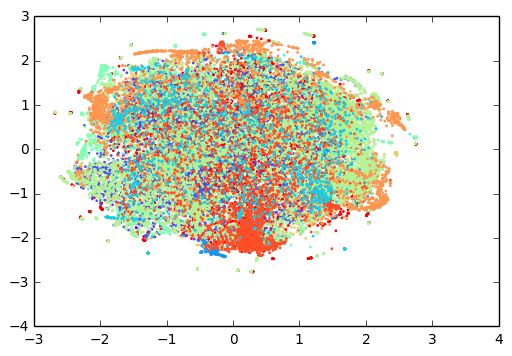

In [8]:
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(doc_vectors)

for x, y, color in zip(Y[:, 0], Y[:, 1], colors):
    plt.scatter(x, y, color=color, s=1);

plt.show()

# Clustering 

In [9]:
def print_cluster_performance(name, predicted):
    print('{}:'.format(name))
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(int_target, predicted)
    print('\thomogenity:\t{}'.format(homogeneity))
    print('\tcompleteness:\t{}'.format(completeness))
    print('\tv-measure:\t{}'.format(v_measure))
    print('')

In [10]:
clustering_names = [
    'MiniBatchKMeans', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']
n_clusters = len(category_names)

# normalize dataset for easier parameter selection
doc_vectors = StandardScaler().fit_transform(doc_vectors)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(doc_vectors, quantile=0.3)

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(doc_vectors, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# create clustering estimators
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                       connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=.2)
affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                   preference=-200)

average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock", n_clusters=n_clusters,
    connectivity=connectivity)

birch = cluster.Birch(n_clusters=n_clusters)
clustering_algorithms = [
    two_means, ms, spectral, ward, average_linkage,
    dbscan, birch]

In [11]:
for name, algorithm in zip(clustering_names, clustering_algorithms):
    %time    predicted = algorithm.fit_predict(doc_vectors)
    print_cluster_performance(name, predicted)

MiniBatchKMeans:
	homogenity:	0.249799761637
	completeness:	0.260849885648
	v-measure:	0.255205264918

MeanShift:
	homogenity:	1.72350864771e-16
	completeness:	1.0
	v-measure:	3.44701729542e-16



/Library/Python/2.7/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering:
	homogenity:	0.0107141351697
	completeness:	0.134840578374
	v-measure:	0.0198509570441



/Library/Python/2.7/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 52 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


Ward:
	homogenity:	0.291982675739
	completeness:	0.290479045347
	v-measure:	0.291228919725



/Library/Python/2.7/site-packages/sklearn/cluster/hierarchical.py:418: UserWarning: the number of connected components of the connectivity matrix is 52 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


AgglomerativeClustering:
	homogenity:	0.0115698806614
	completeness:	0.348445898723
	v-measure:	0.0223961153707

DBSCAN:
	homogenity:	0.0476217078366
	completeness:	0.222668218485
	v-measure:	0.0784627158658

Birch:
	homogenity:	0.297104325085
	completeness:	0.285485005141
	v-measure:	0.291178795675

